# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Цель проекта

Создать модель, которая будет предсказывать вероятность ухода клиента.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**Описание полей:**

BeginDate – дата начала пользования услугами

EndDate – дата окончания пользования услугами

Type – тип оплаты: ежемесячный, годовой и тд

PaperlessBilling – безналичный расчет

PaymentMethod – способ оплаты

MonthlyCharges – ежемесячные траты на услуги

TotalCharges – всего потрачено денег на услуги

Dependents – наличие иждивенцев

Senior Citizen – наличие пенсионного статуса по возрасту

Partner – наличие супруга(и)

MultipleLines – наличие возможности ведения параллельных линий во время звонка

### План проекта

- Постановка задачи и определение конечного результата.
- Загрузка и анализ данных
 - Выводы по итогу анализа данных
- Предобработка
 - Удаление/замена пропусков в данных
 - Работа с дубликатами и типами данных
- Исследовательский анализ
- Сгенерировать дополнительные признаки и целевую переменную
- Построение модели на тренировочных данных(отбор 2-3 моделей, подбор гиперапараметров, обучение)
- Проверка лучшей модели на тестовой выборке
- Общий вывод

### Предварительный анализ данных

In [1]:
%pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.model_selection import cross_val_score

import phik

import time

In [3]:
%pip install scikit-learn==1.1.3

Note: you may need to restart the kernel to use updated packages.


In [4]:
try:
    contract = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')
except:
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')






In [5]:
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [6]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [7]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


1. Пропуски в данных отсутствуют

2. Требуется изменить формат данных в колонках "BeginDate" и "EndDate" на datetime64, "TotalCharges" на float64.


In [8]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [9]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [10]:
personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Пропуски в данных отсутствуют

In [11]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [13]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,1032-MAELW,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Пропуски в данных отсутствуют

In [14]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [15]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [16]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,2683-BPJSO,No
freq,1,3390


Пропуски в данных отсутствуют

# Вывод

1. Пропуски отсутствуют во всех наборах данных.
2. Количество записей не совпадает. В датасетах phone и internet содержится меньше записей, чем в contract и personal. Вероятной причиной может быть то, что некоторые пользователи не используют один из видов связи.  
3. Требуется корректировка названий колонок в датасетах с учетом метода "snake_case".
4. Нужно поменять тип данных в некоторых столбцах contract

### Предобработка данных

Соединим датасеты воедино

In [17]:
df_full = contract.merge(personal, on = 'customerID',how='outer')
df_full = df_full.merge(internet, on = 'customerID',how='outer')
df_full = df_full.merge(phone, on = 'customerID',how='outer')
df_full.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [18]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [19]:
df_full.describe()

,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000
mean,64.761692,0.162147
std,30.090047,0.368612
min,18.250000,0.000000
25%,35.500000,0.000000
50%,70.350000,0.000000
75%,89.850000,0.000000
max,118.750000,1.000000


Исправим названия колонок

In [20]:
df_full.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')

In [21]:

df_full.columns = ['customer_id', 'begin_date', 'end_date', 'type', 
                   'paperless_billing', 'payment_method', 'monthly_charges', 
                   'total_charges', 'gender', 'senior_citizen', 
                   'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 
                   'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies' , 'multiple_lines']
list(df_full)


['customer_id',
 'begin_date',
 'end_date',
 'type',
 'paperless_billing',
 'payment_method',
 'monthly_charges',
 'total_charges',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [22]:
df_full.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Уберем пропуски в данных, заменив их на значение "No"

In [23]:
df_full.fillna('No', inplace=True)
print('\n Кол-во пропусков: ', df_full.isna().sum().sum())


 Кол-во пропусков:  0


Изменим типы данных в соответствии с вышеуказанным.

Пропуски в колонке end_date заменим датой, указанной в задании как актуальной, то есть "2020-02-01". Логично предположить, что если отстутсвует дата окончания, значит на момент выгрузки пользователь является клиентом.

In [24]:
df_full['begin_date'] = df_full['begin_date'].astype('datetime64')

df_full['end_date'] = pd.to_datetime(df_full['end_date'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.date
df_full['end_date'] = df_full['end_date'].fillna('2020-02-01')
df_full['end_date'] = df_full['end_date'].astype('datetime64')

df_full['total_charges'] = pd.to_numeric(df_full['total_charges'], errors='coerce')

In [25]:
df_full['total_charges'].isna().sum()

11

In [26]:
df_full.isna().sum()

customer_id           0
begin_date            0
end_date              0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
gender                0
senior_citizen        0
partner               0
dependents            0
internet_service      0
online_security       0
online_backup         0
device_protection     0
tech_support          0
streaming_tv          0
streaming_movies      0
multiple_lines        0
dtype: int64

Пропусков незначительное количество , поэтому можно удалить.

In [27]:
df_full = df_full.dropna()

Рассмотрим, есть ли в данных явные дубликаты:

In [28]:
df_full.index.duplicated().sum()

0

**Вывод по предобработке**  



В ходе работы с данными выполнено:
 - исправлены названия признаков на sanil_case и нижний регистр;
 - пропуски возникшие при соединении датасетов заменены на значение "No"
 - пропуски в колонке end_date удалены
 - данные исследованы на дубликаты - не обнаружено  
 
Можно приступать к исследовательскому анализу данных

### Исследовательский анализ

Добавим целевой признак target, если клиент покинул компанию - 1, если нет - 0

In [29]:
df_full['target'] = 1
df_full.loc[df_full['end_date'] == '2020-02-01', 'target'] = 0

Рассмотрим предоставленные данные в графике

Проанализируем соотношение ушедших и присутствующих клиентов:

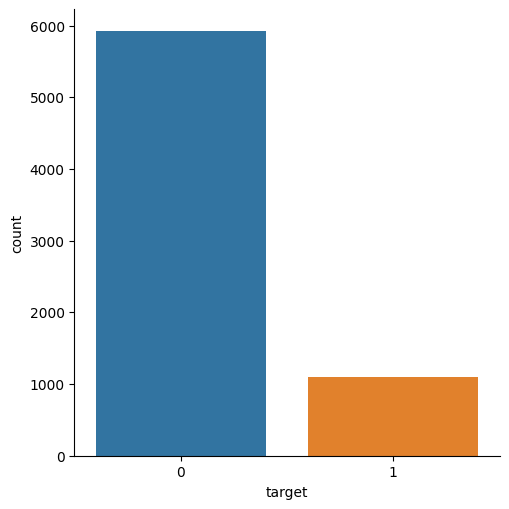

In [30]:
sns.catplot(x='target',data=df_full, kind='count')

Ушедших клиентов 1/6 доля от всех

Взглянем на динамику прихода новых клиентов и сравним с уходом.

<AxesSubplot:>

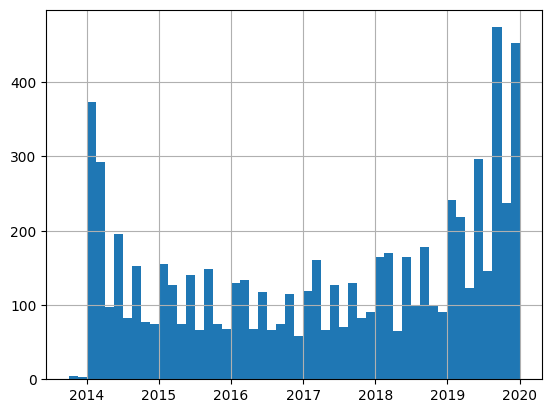

In [31]:
series = df_full['begin_date']
series.hist(bins=50)

Посмотрим динамику ухода клиентов

<AxesSubplot:>

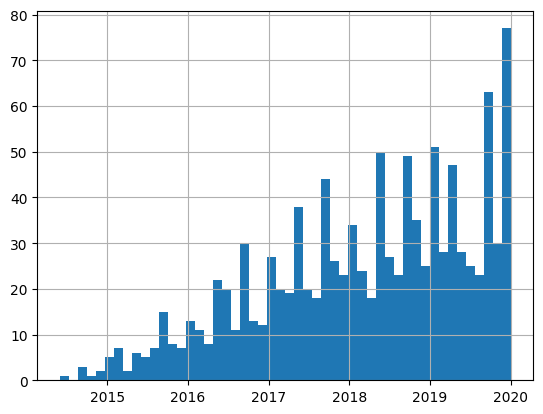

In [32]:

series = df_full['end_date'].loc[df_full['end_date']!= '2020-02-01']
series.hist(bins=50)



In [33]:
target = df_full.loc[df_full['target'] == 1]

In [34]:
not_target = df_full.loc[df_full['target'] == 0]

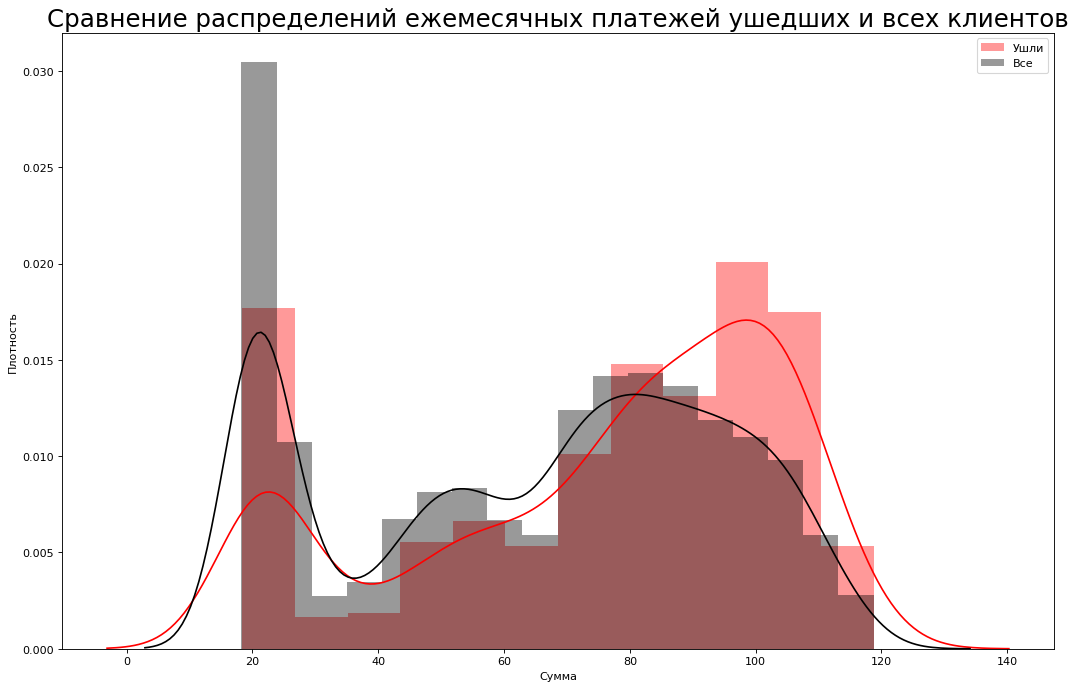

In [35]:
plt.figure(figsize=(16,10), dpi= 80)
sns.distplot(target['monthly_charges'], color="red", label="Ушли")
sns.distplot(df_full['monthly_charges'], color="black", label="Все")

plt.title('Сравнение распределений ежемесячных платежей ушедших и всех клиентов', fontsize=22)
plt.legend()
plt.xlabel('Сумма')
plt.ylabel('Плотность')
plt.show()

Из графика видно, что ушедшие клиенты платили больше оставшихся. Из этого можно сделать вывод, что цена услуг является определяющей для пользователей

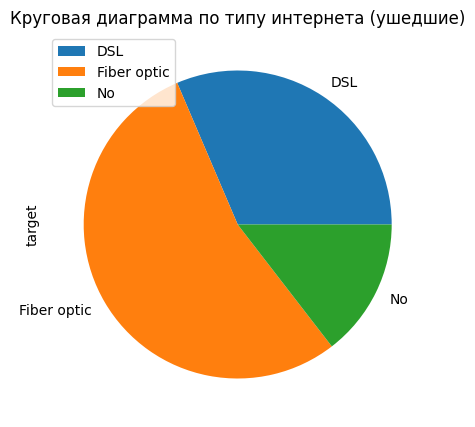

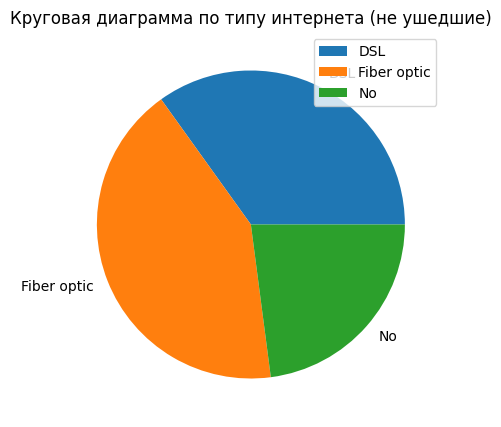

In [36]:
gone =  target.groupby('internet_service')[['target']].count()
not_gone =  not_target.groupby('internet_service')[['target']].count()

gone.plot(kind='pie', subplots=True, figsize=(5, 5))
plt.title("Круговая диаграмма по типу интернета (ушедшие)")
not_gone.plot(kind='pie', subplots=True, figsize=(5, 5))
plt.title("Круговая диаграмма по типу интернета (не ушедшие)")
plt.ylabel("")
plt.show()

Ушедшие клиенты больше пользовались кабельным интернетом, оставшиеся клиенты в рамных долях используют оба типа подключения

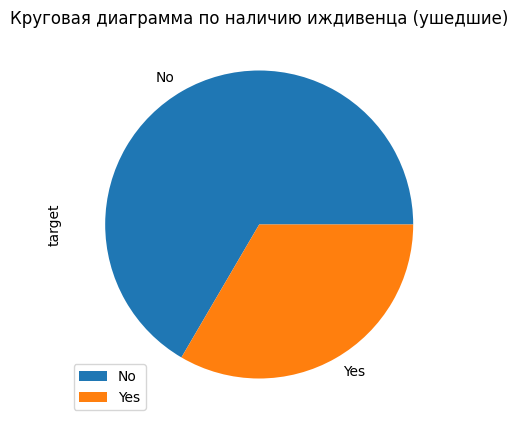

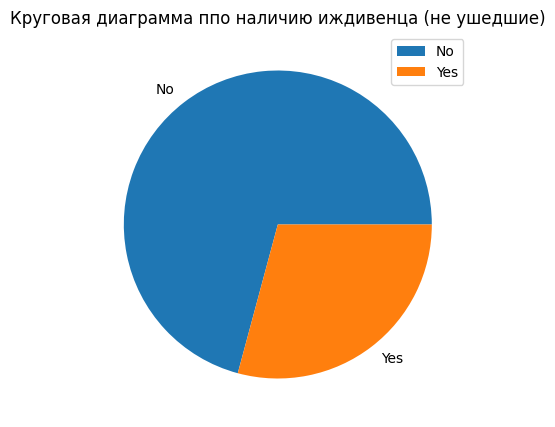

In [37]:
gone =  target.groupby('dependents')[['target']].count()
not_gone =  not_target.groupby('dependents')[['target']].count()

gone.plot(kind='pie', subplots=True, figsize=(5, 5))
plt.title("Круговая диаграмма по наличию иждивенца (ушедшие)")
not_gone.plot(kind='pie', subplots=True, figsize=(5, 5))
plt.title("Круговая диаграмма ппо наличию иждивенца (не ушедшие)")
plt.ylabel("")
plt.show()

В данных преобладают клиенты без иждивенцев, как в случае ушедших, так в оставшихся

Посмотрим на баланс классов

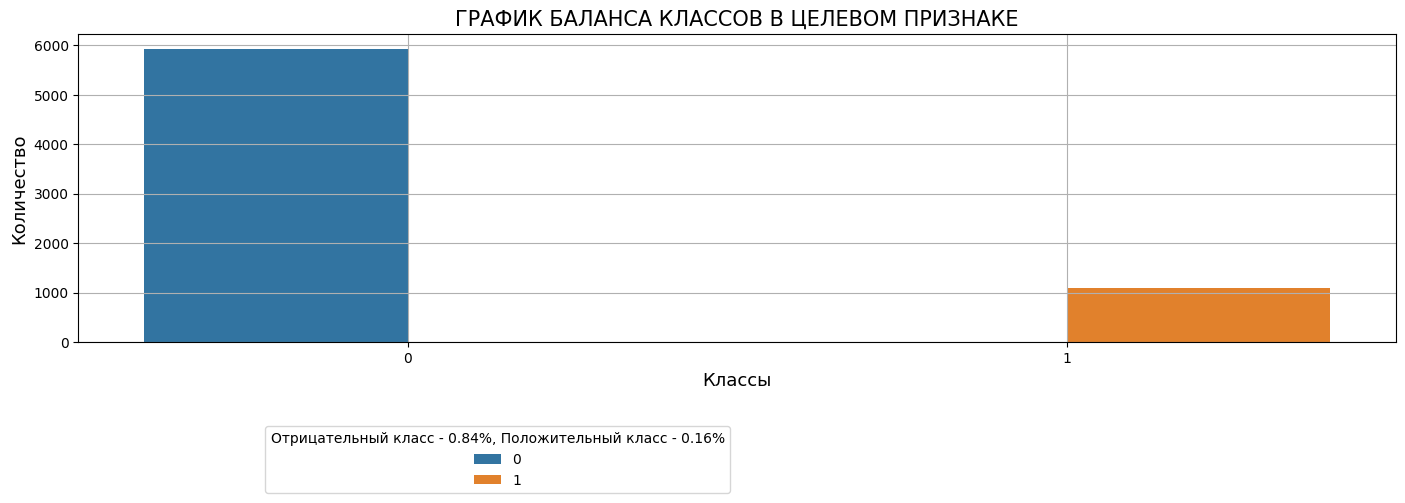

In [38]:

plt.figure(figsize=[17, 4])
plt.title('ГРАФИК БАЛАНСА КЛАССОВ В ЦЕЛЕВОМ ПРИЗНАКЕ', fontsize=15)
sns.barplot(x=df_full['target'].value_counts().index,
            y=df_full['target'].value_counts(),
            hue=df_full['target'].value_counts().index)
plt.ylabel('Количество', fontsize=13)
plt.xlabel('Классы', fontsize=13)
plt.grid(True)
negative_class = df_full['target'].value_counts(normalize=True)[0]
positive_class = df_full['target'].value_counts(normalize=True)[1]
plt.legend(title=f'Отрицательный класс - {negative_class:.2f}%, Положительный класс - {positive_class:.2f}%', 
           bbox_to_anchor=(0.5, -0.25))
plt.show();

Присутствует дисбаланс классов

Добавим признак показывающий продолжительность пользования услугами

In [39]:
df_full['duration'] = df_full['end_date'] - df_full['begin_date']
df_full.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,No,0,31 days
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036 days
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123 days


In [40]:
df_full['duration'] = df_full['duration'].dt.days

In [41]:
df_full['duration'].describe()

count    7032.000000
mean      899.961320
std       682.738777
min        28.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: duration, dtype: float64

In [42]:
cols_cat = ['type', 'paperless_billing', 'payment_method', 'partner', 'dependents', 
           'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
           'streaming_tv', 'streaming_movies', 'multiple_lines']

In [43]:
df_phik = df_full[cols_cat]
phik_overview = df_phik.phik_matrix()
phik_overview.round(2)

,type,paperless_billing,payment_method,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
type,1.00,0.11,0.28,0.18,0.15,0.50,0.15,0.10,0.14,0.18,0.07,0.07,0.07
paperless_billing,0.11,1.00,0.37,0.01,0.17,0.23,0.00,0.20,0.16,0.06,0.34,0.33,0.25
payment_method,0.28,0.37,1.00,0.24,0.22,0.32,0.26,0.28,0.31,0.27,0.38,0.38,0.34
partner,0.18,0.01,0.24,1.00,0.65,0.00,0.22,0.22,0.24,0.19,0.19,0.18,0.22
dependents,0.15,0.17,0.22,0.65,1.00,0.11,0.12,0.03,0.01,0.10,0.02,0.06,0.03
internet_service,0.50,0.23,0.32,0.00,0.11,1.00,0.24,0.23,0.23,0.24,0.27,0.27,0.23
online_security,0.15,0.00,0.26,0.22,0.12,0.24,1.00,0.43,0.42,0.53,0.27,0.29,0.15
online_backup,0.10,0.20,0.28,0.22,0.03,0.23,0.43,1.00,0.46,0.44,0.43,0.42,0.31
device_protection,0.14,0.16,0.31,0.24,0.01,0.23,0.42,0.46,1.00,0.50,0.57,0.59,0.31
tech_support,0.18,0.06,0.27,0.19,0.10,0.24,0.53,0.44,0.50,1.00,0.42,0.43,0.16


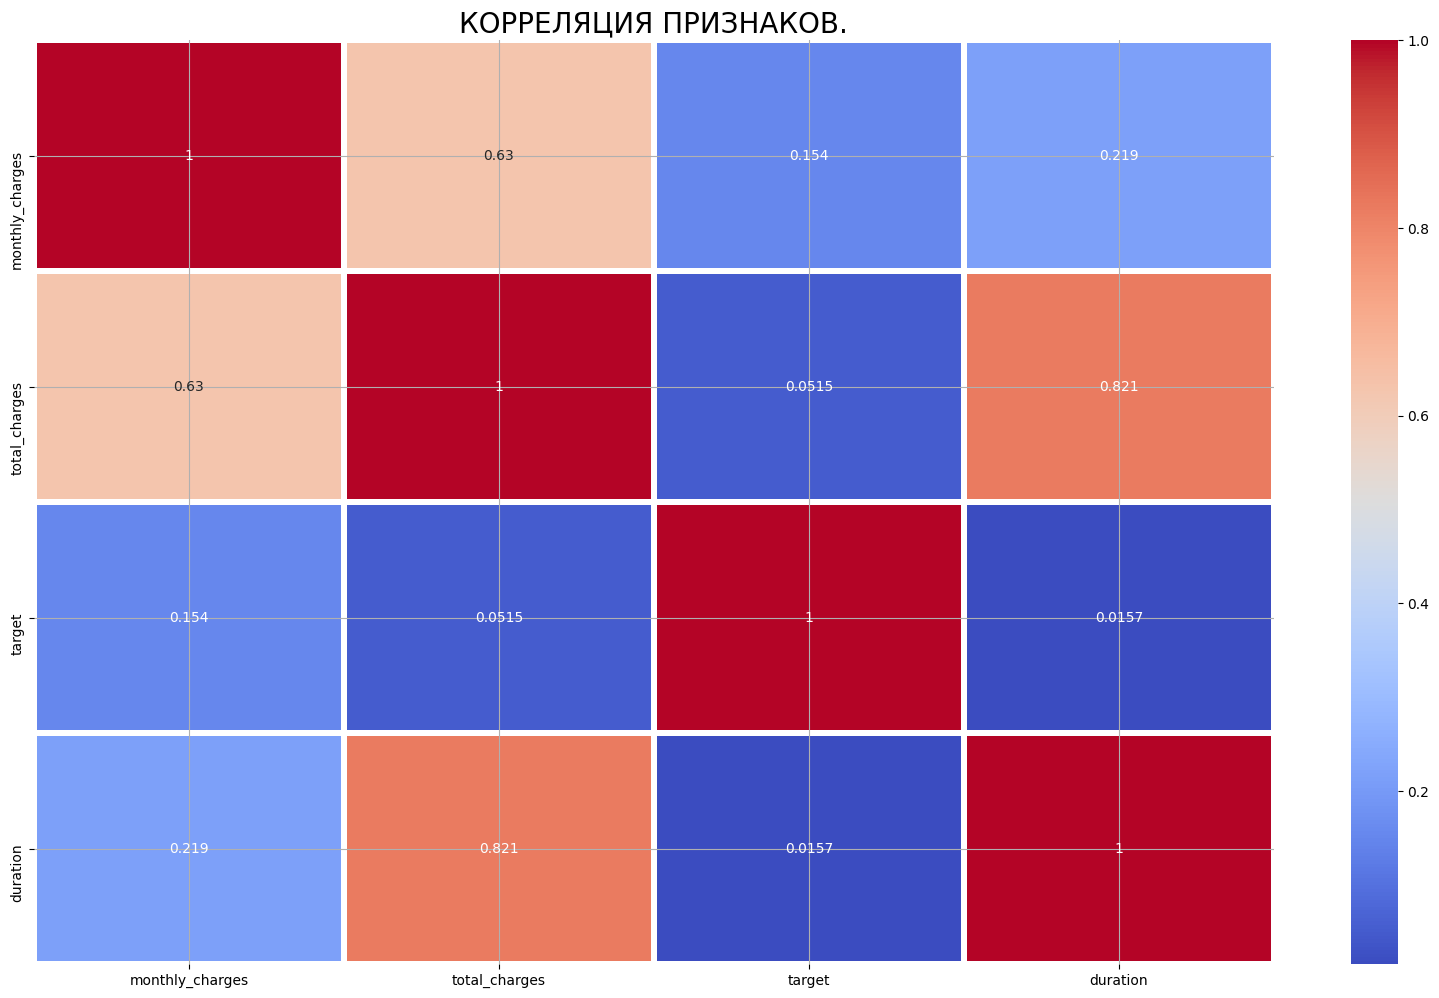

In [44]:
numeric2 = ['monthly_charges','total_charges', 'target', 'duration']
cor = df_full[numeric2].corr()
fig, ax = plt.subplots(figsize=(20,12))
plt.title('КОРРЕЛЯЦИЯ ПРИЗНАКОВ.', fontsize=20)
sns.heatmap(cor, annot=True, cmap="coolwarm",  fmt='.3g', linewidth=4)
plt.grid(True);

Сильная кореляция замечена между признаками total_charges и duration , удалим столец total charges

In [45]:
df_full.drop(['total_charges'], axis=1, inplace=True)

**Вывод по исследовательскому анализу**  

Исследование данных дало следующие данные:
- В данных преимущественно находятся оставшиеся на 1 февраля 2020 года пользователи, ушедших до этой даты примерно 1/6.
- На графиках заметны периоды, когда пользователи уходили больше - скорее всего связано с повышением тарифов.
- клиенты приходили в компанию в большом количестве в 2014-2015 годах и в 2019-2020

### Построение моделей

Удалим ненужные колонки

In [46]:
df_full.drop(['customer_id', 'begin_date', 'end_date', 'gender'], axis= 1 , inplace= True )


Дату начало и окончания контракта удалим, так как вместо них добавил столбец с длительностью контракта.

Признак идентификатора клиента и пол также не играют роли при обучении модели.

In [47]:
df_full.head(3)

,type,paperless_billing,payment_method,monthly_charges,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,duration
0,Month-to-month,Yes,Electronic check,29.85,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31
1,One year,No,Mailed check,56.95,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123


Закодируем данные методом OHE

In [48]:
target = df_full['target'].astype('int')
features = df_full.drop(['target'], axis=1)

In [49]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=240423)

In [50]:
cols_cat = ['type', 'paperless_billing', 'payment_method', 'partner', 'dependents', 'senior_citizen',
           'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
           'streaming_tv', 'streaming_movies', 'multiple_lines']

In [51]:
encoder = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder.fit(features_train[cols_cat])

OneHotEncoder(drop='first', sparse=False)

In [52]:
# добавляем закодированные признаки
features_train[
    encoder.get_feature_names_out()
] = encoder.transform(features_train[cols_cat])
# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train= features_train.drop(cols_cat, axis=1)


In [53]:
#отмасштабируем количественные признаки
numeric = ['monthly_charges','duration']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])


**LOGISTIC_REGRESSION**

In [54]:
model_regress = LogisticRegression(solver = 'liblinear')

penalty = ['l1', 'l2']
C = np.logspace(-4, 4, 50)
class_weight = [None, 'balanced']

hyperparameters = dict(C=C, penalty=penalty, class_weight=class_weight)

rs_regress = RandomizedSearchCV(model_regress, 
                                hyperparameters, 
                                cv = 5,
                                n_iter = 10,
                                random_state = 0,
                                verbose = 0, 
                                n_jobs = 1, 
                                scoring = 'roc_auc')
#обучение
start = time.time()    
rs_regress.fit(features_train, target_train)
train_time_logreg = time.time() - start
#предсказание
start = time.time()  
target_pred = rs_regress.predict(features_train)
predict_time_logreg = time.time() - start
#расчёт метрик
roc_auc_logreg =  rs_regress.best_score_
accuracy_logreg = cross_val_score(rs_regress.best_estimator_, features_train, target_train, scoring = 'accuracy').mean()



print('Время обучения: ', round(train_time_logreg, 2), 'сек')
print('Время предсказания: ', round(predict_time_logreg, 2), 'сек')
print('ROC-AUC модели: ', round(roc_auc_logreg, 2))
print('Accuracy модели: ', round(accuracy_logreg, 2))


Время обучения:  3.69 сек
Время предсказания:  0.0 сек
ROC-AUC модели:  0.76
Accuracy модели:  0.7


Mетрика auc-roc не устраивает условию => 0.85

**RANDOM_FOREST_CLASSIFIER**

In [55]:
model_forest = RandomForestClassifier()
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 50, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10)]
criterion = ['gini', 'entropy']
class_weight = [None, 'balanced']

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion}

rs_forest = RandomizedSearchCV(model_forest,
                               param_dist,
                               cv = 5,
                               n_iter = 10,
                               random_state = 0,
                               verbose = 0, 
                               n_jobs= 1, 
                               scoring = 'roc_auc')
#обучение
start = time.time()    
rs_forest.fit(features_train, target_train)
train_time_forst = time.time() - start
#предсказание
start = time.time()  
target_pred = rs_forest.predict(features_train)
predict_time_forst = time.time() - start
#расчёт метрик
roc_auc_forst =  rs_forest.best_score_
accuracy_forst = cross_val_score(rs_forest.best_estimator_, features_train, target_train, scoring = 'accuracy').mean()



print('Время обучения: ', round(train_time_forst, 2), 'сек')
print('Время предсказания: ', round(predict_time_forst, 2), 'сек')
print('ROC-AUC модели: ', round(roc_auc_forst, 2))
print('Accuracy модели: ', round(accuracy_forst, 2))


Время обучения:  4.34 сек
Время предсказания:  0.03 сек
ROC-AUC модели:  0.81
Accuracy модели:  0.85


roc-auc всё еще меньше нужного

Третьей моделью выберу lGBM, модель бустинга, её отличие в ненадобности кодировки данных, нужно перевести данные в тип category

**LGBMClassifier**

In [56]:
cols_cat = ['type', 'paperless_billing', 'payment_method', 'partner', 'dependents', 'senior_citizen',
           'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
           'streaming_tv', 'streaming_movies', 'multiple_lines']
for col in cols_cat:
    df_full[col] = df_full[col].astype('category')

In [57]:
target_boost = df_full['target']
features_boost = df_full.drop('target', axis=1)

features_train_boost, features_test_boost, target_train_boost, target_test_boost = train_test_split(
                                      features_boost, target_boost, test_size=0.25, random_state = 240323)

print('Размер таблицы признаков обучающей выборки: ', features_train_boost.shape)
print('Размер таблицы признаков тестовой выборки: ', features_test_boost.shape)


Размер таблицы признаков обучающей выборки:  (5274, 16)
Размер таблицы признаков тестовой выборки:  (1758, 16)


In [58]:

#Применим масштабирование числовых признаков:

scaler.fit(features_train_boost[numeric])

features_train_boost[numeric] = scaler.transform(features_train_boost[numeric])


In [59]:
model = LGBMClassifier(objective='binary', metric='auc')

params = [{'learning_rate': [1],
                      'n_estimators': [300],
                      'num_leaves': [20],
                      'class_weight': ['balanced']}]


rs_lgbm = RandomizedSearchCV(model, 
                        params, 
                        cv = 5, 
                        n_iter=5,
                        random_state=240323,
                        verbose = 0, 
                        n_jobs=1,
                        scoring={'AUC':'roc_auc'},
                        refit='AUC')

#обучение
start = time.time()    
rs_lgbm.fit(features_train_boost, target_train_boost)
train_time_lgbm = time.time() - start
#предсказание
start = time.time()  
target_pred = rs_lgbm.predict(features_train_boost)
predict_time_lgbm = time.time() - start
#расчёт метрик
roc_auc_lgbm = rs_lgbm.best_score_
accuracy_lgbm = cross_val_score(rs_lgbm.best_estimator_, features_train_boost, target_train_boost, scoring = 'accuracy').mean()


print('Время обучения: ', round(train_time_lgbm, 2), 'сек')
print('Время предсказания: ', round(predict_time_lgbm, 2), 'сек')
print('ROC-AUC модели: ', round(roc_auc_lgbm, 2))
print('Accuracy модели: ', round(accuracy_lgbm, 2))


Время обучения:  2.27 сек
Время предсказания:  0.06 сек
ROC-AUC модели:  0.86
Accuracy модели:  0.89


Нужные результаты достигнуты, auc-roc > 0.85

Составим сводную таблицу

In [60]:
data = {'AUC-ROC':[roc_auc_logreg, roc_auc_forst, roc_auc_lgbm],
        'Accuracy':[accuracy_logreg, accuracy_forst, accuracy_lgbm],
       'Train time, сек':[train_time_logreg, train_time_forst, train_time_lgbm],
       'Predict time, сек':[predict_time_logreg, predict_time_forst, predict_time_lgbm]}

table_compare = pd.DataFrame(data)
pd.set_option('display.float_format', '{:.2f}'.format)
table_compare.index = ['LogisticRegression', 'RandomForestClassifer', 'LGBMCLassifier']
display(table_compare)

,AUC-ROC,Accuracy,"Train time, сек","Predict time, сек"
LogisticRegression,0.76,0.70,3.69,0.00
RandomForestClassifer,0.81,0.85,4.34,0.03
LGBMCLassifier,0.86,0.89,2.27,0.06


Лучшая модель lgbmClasifier,однако обучение происходит на платформе с значительной продолжительностью(иногда 40 минут, иногда 10 и т.д). Её применим в тестировании

### Тест

In [61]:
#Применим масштабирование числовых признаков:

features_test_boost[numeric] = scaler.transform(features_test_boost[numeric])

In [62]:
%%time
roc_auc_test = roc_auc_score(target_test_boost, rs_lgbm.best_estimator_.predict_proba(features_test_boost)[:, 1])
print('Метрика roc_auc :', round(roc_auc_test, 3))

Метрика roc_auc : 0.901
CPU times: total: 78.1 ms
Wall time: 31.9 ms


In [63]:
%%time
accuracy_test = accuracy_score(target_test, rs_lgbm.best_estimator_.predict(features_test_boost))
print('Метрика accuracy :', round(accuracy_test, 3))

Метрика accuracy : 0.75
CPU times: total: 109 ms
Wall time: 76.8 ms


Требуемая метрика auc-roc достигнута, задача выполнена.

**Вывод**  

- Данные проанализированы, исследованы зависимости признаков, удалены ненужные признаки, добавлен признак длительности контракта;
- Данные закодированы и разделены на тренировочную и тестовую выборки, построены 3 модели: Логистическая регрессия, Случайный Лес и LGBM бустинг;
- По итогам 3-я модель оказалась наиболее точной, на тестовой выборке достигнута требуемая метрика auc-roc,

### Отчёт

В ходе работы над задачей выполнил следующие действия исходя из поставленного плана:
- **Проанализировал предоставленные датасеты contract, phone, personal и internet, которые содержали следующие признаки**
  - contract: CustomerID - индикатор клиента, BeginDate – дата начала пользования услугами, EndDate – дата окончания пользования услугами, Type – тип оплаты: ежемесячный, годовой и тд, PaperlessBilling – безналичный расчет, PaymentMethod – способ оплаты, MonthlyCharges – ежемесячные траты на услуги, TotalCharges - итоговые затраты.
  - phone: CustomerID - индикатор клиента, MultipleLines - многоканальная связь.
  - personal: customerID, Dependents – наличие иждивенцев, Senior Citizen – наличие пенсионного статуса по возрасту, Partner – наличие супруга(и)
  - internet: customerID, InternetService, OnlineSecurity - антивирус, OnlineBackup - резерв.копир., DeviceProtection - защита, TechSupport -поддержка, StreamingTV -тв, StreamingMovies -фильмы.
- **Данные были объединены в общий датасет df_full, пропуски в данных были заменены на значение No, так как являлись отсутствием у клиента определенной функции**
- **Для обучения моделей был сгенерирован целевой признак target, который показывает ушёл клиент или нет(1 ушел, 0 - нет)**
- **После анализа данных пришёл к выводу, что не все признаки будут нужны для построения моделей, поэтому были удалены признаки:**
  - begin_date и end_date - вместо них создал доп признак длительность контракта(duration)
  - customer_id, gender - не играют роли при обучении
  - total_charges - имеет сильную корреляцию с признаком duration
- **Итого используемые признаки при обучении:** type,	paperless_billing, payment_method, monthly_charges,	senior_citizen,	partner	dependents,	internet_service,	online_security,	online_backup,	device_protection,	tech_support,	streaming_tv,	streaming_movies,	multiple_lines,	target,	duration;
  

**Лучшей моделью на тренировочных данных оказалась модель бустинга LGBMClassifier.**  
**Eё параметры:**
- learning_rate = 1,
- n_estimators = 300,
- num_leaves = 20
- class_weight = "balanced"
- n_jobs = 1
- cv =5,
- n_iter = 5 

Random_state = 240423

Размер таблицы признаков тестовой выборки:  (1758, 16)

Отклонений от исходного плана нет.

Самое трудное для меня было выбрать оптимальные показатели для визуализации в исследовательском анализе, подбор гипер параметров для моделей, чтобы добиться нужной метрики

Ключевыми этапами считаю анализ данных, добавление и удаление признаков, а также построение и выбор наилучшей модели обучения. В основном же проект -  как цельная работа, в котором важны все этапы.